# **BUILD VARIATIONAL AUTOENCODER FROM SCRATCH**

In [1]:
import torch 
from torch import nn

## Build the variational autoencoder model

In [2]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, 
                 input_dimension : int,
                 hidden_layer_dimension : int,
                 latent_space_dimension : int
            ):
        super().__init__()

        # construct encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dimension, hidden_layer_dimension),
            nn.ReLU()
        )

        # mean, log-variance
        self.mean = nn.Linear(hidden_layer_dimension, latent_space_dimension)
        self.log_variance = nn.Linear(hidden_layer_dimension, latent_space_dimension)

        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(latent_space_dimension, hidden_layer_dimension),
            nn.ReLU(),
            nn.Linear(hidden_layer_dimension, input_dimension),
            nn.Sigmoid()       # ensure all the values are within (0, 1)
        )

    def reparameterization(self, mean, log_variance):
        stdd = torch.exp(0.5 * log_variance)
        epsilon = torch.rand_like(stdd)
        return mean + log_variance * epsilon

    def forward(self, x):
        # input -> encode -> reparameterization trick -> decode -> output
        input_ = x.view(x.size(0), -1)
        encoded = self.encoder(input_)
        mean, log_variance = self.mean(encoded), self.log_variance(encoded)
        z = self.reparameterization(mean,log_variance)
        decoded = self.decoder(z)
        return decoded, mean, log_variance
        

## Implement Training loop on MNIST

### 1.Import all dependencies

In [13]:
import torch 
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from tqdm import tqdm
import matplotlib.pyplot as plt

### 2. Data Preparation step

In [15]:
# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the dataset
train_dataset = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_dataset = datasets.MNIST(root = './data', train =True, download = True, transform = transform)

# Dataloader
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 64,
    shuffle = True
)

### 3. Defining Loss Function

**Loss Function = Binary Cross Entropy + KL Divergence**

Here, 
**Binary Cross Entropy** measures the quality of reconstructed image



**Kellback Leibler Divergence** measures the distance between two Probability distributions. 

here, it measure the distance between the distribution learned by model and distribution we want(Multivariate Gaussian Distribution)

In [5]:
def loss_function(recons_x, x, mean, log_variance):
    # compute the loss using BCE (Binary Cross Entropy) --> -W{(y * log(x)) + ((1-y) * (1 - log(1-x))}
    loss = F.binary_cross_entropy(recons_x, x.view(-1, 784), reduction = 'sum')
    kl_divergence = -(0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()))

    # add both loss and kl_divergence and return 
    return loss + kl_divergence

### 4. Training Loop

In [8]:
def train(model, optimizer, train_loader, device):
    model.train()

    # track total_loss
    total_loss = 0 

    for (img, label) in tqdm(train_loader):
        # move image to device
        img = img.to(device)

        # pass it through model
        recons_img, mean, log_variance = model(img)

        # compute loss
        loss = loss_function(recons_img, img, mean, log_variance)
        total_loss += loss

        # optimizer
        optimizer.zero_grad()

        # loss backpropagation
        loss.backward()

        # optimizer updates
        optimizer.step()
        
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Train Loss: {avg_loss:.4f}")
    

### 5. Testing Loop

In [19]:
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    
    with torch.no_grad():
        for data, _ in tqdm(test_loader):
            data = data.to(device)
            recon_batch, mu, log_var = model(data)
            
            test_loss += loss_function(recon_batch, data, mu, log_var).item()

    avg_loss = test_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")


In [22]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model initialization
model = VariationalAutoEncoder(784, 400, 20).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training process
epochs = 30
for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    train(model, optimizer, train_loader, device)
    test(model, test_loader, device)


Epoch 1/30


100%|██████████| 938/938 [00:07<00:00, 117.64it/s]


Train Loss: 150.0117


100%|██████████| 938/938 [00:06<00:00, 143.28it/s]


Test Loss: 105.1118

Epoch 2/30


100%|██████████| 938/938 [00:08<00:00, 116.10it/s]


Train Loss: 97.0901


100%|██████████| 938/938 [00:06<00:00, 144.17it/s]


Test Loss: 91.4000

Epoch 3/30


100%|██████████| 938/938 [00:08<00:00, 116.09it/s]


Train Loss: 88.5496


100%|██████████| 938/938 [00:06<00:00, 145.64it/s]


Test Loss: 85.8898

Epoch 4/30


100%|██████████| 938/938 [00:08<00:00, 115.47it/s]


Train Loss: 84.2213


100%|██████████| 938/938 [00:06<00:00, 145.83it/s]


Test Loss: 82.6573

Epoch 5/30


100%|██████████| 938/938 [00:07<00:00, 117.73it/s]


Train Loss: 81.3589


100%|██████████| 938/938 [00:06<00:00, 145.18it/s]


Test Loss: 80.2667

Epoch 6/30


100%|██████████| 938/938 [00:08<00:00, 115.57it/s]


Train Loss: 79.2507


100%|██████████| 938/938 [00:06<00:00, 144.80it/s]


Test Loss: 78.2935

Epoch 7/30


100%|██████████| 938/938 [00:07<00:00, 117.77it/s]


Train Loss: 77.6234


100%|██████████| 938/938 [00:06<00:00, 143.84it/s]


Test Loss: 76.7760

Epoch 8/30


100%|██████████| 938/938 [00:08<00:00, 116.19it/s]


Train Loss: 76.3179


100%|██████████| 938/938 [00:06<00:00, 144.75it/s]


Test Loss: 75.7061

Epoch 9/30


100%|██████████| 938/938 [00:07<00:00, 118.35it/s]


Train Loss: 75.2366


100%|██████████| 938/938 [00:06<00:00, 145.17it/s]


Test Loss: 74.6399

Epoch 10/30


100%|██████████| 938/938 [00:07<00:00, 118.11it/s]


Train Loss: 74.3252


100%|██████████| 938/938 [00:06<00:00, 143.23it/s]


Test Loss: 73.8549

Epoch 11/30


100%|██████████| 938/938 [00:07<00:00, 118.09it/s]


Train Loss: 73.5620


100%|██████████| 938/938 [00:06<00:00, 145.77it/s]


Test Loss: 73.0847

Epoch 12/30


100%|██████████| 938/938 [00:08<00:00, 117.06it/s]


Train Loss: 72.8894


100%|██████████| 938/938 [00:06<00:00, 143.57it/s]


Test Loss: 72.5382

Epoch 13/30


100%|██████████| 938/938 [00:07<00:00, 117.66it/s]


Train Loss: 72.3057


100%|██████████| 938/938 [00:06<00:00, 145.79it/s]


Test Loss: 72.0028

Epoch 14/30


100%|██████████| 938/938 [00:08<00:00, 117.00it/s]


Train Loss: 71.8015


100%|██████████| 938/938 [00:06<00:00, 145.27it/s]


Test Loss: 71.5524

Epoch 15/30


100%|██████████| 938/938 [00:07<00:00, 117.63it/s]


Train Loss: 71.3426


100%|██████████| 938/938 [00:06<00:00, 146.35it/s]


Test Loss: 70.9804

Epoch 16/30


100%|██████████| 938/938 [00:07<00:00, 117.85it/s]


Train Loss: 70.9406


100%|██████████| 938/938 [00:06<00:00, 145.18it/s]


Test Loss: 70.6387

Epoch 17/30


100%|██████████| 938/938 [00:07<00:00, 117.49it/s]


Train Loss: 70.5560


100%|██████████| 938/938 [00:06<00:00, 144.71it/s]


Test Loss: 70.3049

Epoch 18/30


100%|██████████| 938/938 [00:07<00:00, 117.66it/s]


Train Loss: 70.2393


100%|██████████| 938/938 [00:06<00:00, 143.92it/s]


Test Loss: 69.9097

Epoch 19/30


100%|██████████| 938/938 [00:08<00:00, 116.68it/s]


Train Loss: 69.9205


100%|██████████| 938/938 [00:06<00:00, 145.01it/s]


Test Loss: 69.7170

Epoch 20/30


100%|██████████| 938/938 [00:07<00:00, 117.45it/s]


Train Loss: 69.6511


100%|██████████| 938/938 [00:06<00:00, 144.37it/s]


Test Loss: 69.3898

Epoch 21/30


100%|██████████| 938/938 [00:08<00:00, 116.45it/s]


Train Loss: 69.3940


100%|██████████| 938/938 [00:06<00:00, 145.93it/s]


Test Loss: 69.1565

Epoch 22/30


100%|██████████| 938/938 [00:07<00:00, 118.57it/s]


Train Loss: 69.1569


100%|██████████| 938/938 [00:06<00:00, 144.68it/s]


Test Loss: 68.9296

Epoch 23/30


100%|██████████| 938/938 [00:07<00:00, 117.86it/s]


Train Loss: 68.9367


100%|██████████| 938/938 [00:06<00:00, 143.81it/s]


Test Loss: 68.7538

Epoch 24/30


100%|██████████| 938/938 [00:07<00:00, 117.77it/s]


Train Loss: 68.7328


100%|██████████| 938/938 [00:06<00:00, 144.07it/s]


Test Loss: 68.4102

Epoch 25/30


100%|██████████| 938/938 [00:07<00:00, 117.56it/s]


Train Loss: 68.5398


100%|██████████| 938/938 [00:06<00:00, 141.76it/s]


Test Loss: 68.3020

Epoch 26/30


100%|██████████| 938/938 [00:07<00:00, 118.04it/s]


Train Loss: 68.3623


100%|██████████| 938/938 [00:06<00:00, 144.56it/s]


Test Loss: 68.1383

Epoch 27/30


100%|██████████| 938/938 [00:07<00:00, 117.40it/s]


Train Loss: 68.2001


100%|██████████| 938/938 [00:06<00:00, 143.61it/s]


Test Loss: 67.9116

Epoch 28/30


100%|██████████| 938/938 [00:07<00:00, 117.96it/s]


Train Loss: 68.0346


100%|██████████| 938/938 [00:06<00:00, 144.60it/s]


Test Loss: 67.9155

Epoch 29/30


100%|██████████| 938/938 [00:07<00:00, 118.15it/s]


Train Loss: 67.9025


100%|██████████| 938/938 [00:06<00:00, 144.96it/s]


Test Loss: 67.7879

Epoch 30/30


100%|██████████| 938/938 [00:08<00:00, 116.60it/s]


Train Loss: 67.7563


100%|██████████| 938/938 [00:06<00:00, 144.97it/s]

Test Loss: 67.5145


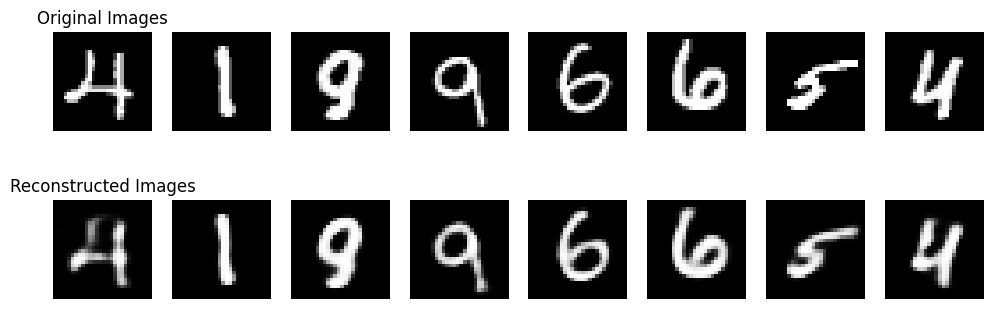

In [21]:
def visualize_results(model, test_loader, device, num_images=8):
    model.eval()
    
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_data, _, _ = model(data)

        # Display Original vs Reconstructed
        fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
        for i in range(num_images):
            # Original
            axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')

            # Reconstructed
            axes[1, i].imshow(recon_data[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')

        axes[0, 0].set_title('Original Images')
        axes[1, 0].set_title('Reconstructed Images')
        plt.show()

visualize_results(model, test_loader, device)
